In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from specim.specfuncs import spec1d

In [2]:
data =  spec1d.Spec1d('../RXJ1131_spec.fits', informat='mwa')
lamda_galaxy = data['wav']
spectra_galaxy = data['flux']
variance_spectra_galaxy = data['var']


Reading spectrum from ../RXJ1131_spec.fits
Expected file format: mwa
 Spectrum Start:  5020.78
 Spectrum End:     8219.18
 Dispersion (1st pixel):   0.80
 Dispersion (average):      0.80



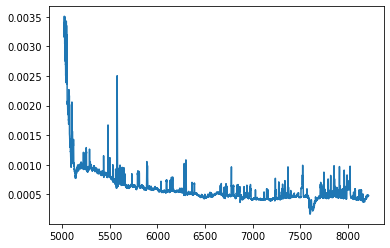

In [3]:
#%matplotlib notebook
plt.plot(lamda_galaxy, variance_spectra_galaxy)

### Below is the list of sky lines (in terms of wavelength) we would like to fit with a Gaussian distribution. The tuples contains start and end value of the wavelength range for thses sky lines. However they are not the exact wavelength data points in the spectra as we have collected these wavelength values from the zoomed out plot of the emission lines. So we have to replace these wavelength values with the closest wavelengths values from the spectra.

In [14]:
#sky_lines = [(5222.36, 5223.99), (5251.16, 5255.98), (5286.38, 5287.99), (5434.34, 5436.17),
#                  (5479.04, 5485.16), (5496.74, 5502.49), (5530.01, 5534.49), (5573.39, 5581.98),
#                  (5646.79, 5652.15), (5800.77, 5811.93), (6091.94, 6101.64), (6146.86, 6148.82),
#                  (6295.94, 6304.79), (6360.53, 6368.14), (6668.21, 6673.39), (6720.64, 6725.75),
#                  (6775.97, 6781.59), (6793.08, 6803.17), (7028.67, 7032.81), (7143.81, 7155.07),
#                  (7271.46, 7280.36), (7364.82, 7381.76), (7747.07, 7755.18), (7817.56, 7825.60),
#                  (7909.53, 7916.84), (7961.31, 7967.21), (8074.97, 8081.67)]

sky_lines = [(5528.88, 5535.12), (5573.39, 5583.50), (6295.94, 6304.79), (6359.04, 6368.50),
                  (7271.46, 7280.36), (7747.07, 7755.18), (7817.56, 7825.60), (7908.28, 7917.50)] 
                 # [(7960.00, 7967.21), (8022.30, 8030.00), (6668.21, 6673.39)]

In [15]:
exact_sky_lines = []
index = []
for i,p in enumerate(sky_lines):
    a = abs(lamda_galaxy - p[0])
    b = abs(lamda_galaxy - p[1])
    a_list = a.tolist()
    b_list = b.tolist()
    start = lamda_galaxy[a_list.index(min(a))]
    stop = lamda_galaxy[b_list.index(min(b))]
    exact_sky_lines.append((start, stop))
    index.append((a_list.index(min(a)), b_list.index(min(b))))

In [16]:
print("sky_lines : \n")
[print(*line) for line in sky_lines]
print("\nexact_sky_lines : \n")
[print(*line) for line in exact_sky_lines]

sky_lines : 

5528.88 5535.12
5573.39 5583.5
6295.94 6304.79
6359.04 6368.5
7271.46 7280.36
7747.07 7755.18
7817.56 7825.6
7908.28 7917.5

exact_sky_lines : 

5528.783203120122 5535.183203120124
5573.583203120133 5583.183203120135
6295.983203120297 6304.783203120299
6359.183203120311 6368.783203120313
7271.183203120519 7279.983203120521
7747.183203120627 7755.183203120629
7817.583203120643 7825.583203120645
7907.983203120663 7917.5832031206655


[None, None, None, None, None, None, None, None]

In [17]:
# empty list to contain data of these sky lines 
data_sky_line = []           
lamda_sky_line = [] 

### Collecting the variance on spectra data for specific range of wavelengths of the sky lines to fit with Gaussian distribution.

In [18]:
lam_list = lamda_galaxy.tolist()                   # converting array to list
var_spec_list = variance_spectra_galaxy.tolist()   # contains variance on spectra data

for i,p in enumerate(exact_sky_lines):
    start = lam_list.index(p[0])
    stop  = lam_list.index(p[1])
    var_spec = var_spec_list[start:stop+1]   # slicing and collecting data for the wavelength range
    lam = lam_list[start:stop+1]
    data_sky_line.append(var_spec)
    lamda_sky_line.append(lam)

### Here is the plot of emission lines we are going to fit

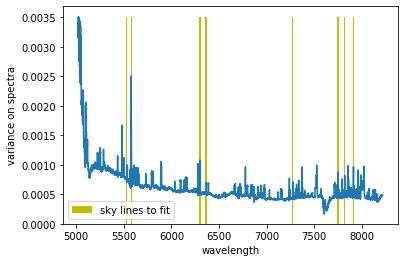

In [19]:
s = np.zeros(len(lamda_sky_line))
w = np.zeros(len(lamda_sky_line))
for i,p in enumerate(lamda_sky_line):
    s[i]= np.median(p)
    w[i]= len(p)

plt.plot(lamda_galaxy, variance_spectra_galaxy)
plt.bar(s, height=max(variance_spectra_galaxy), width=w, color='y', label='sky lines to fit')
plt.xlabel('wavelength')
plt.ylabel('variance on spectra')
plt.legend()
plt.show()

In [20]:
model_gauss = models.Gaussian1D()           # calling the Gaussian model 
fitter_gauss = fitting.LevMarLSQFitter()    # Calling the fitting scheme 

###  Here we are going to fit each sky line data individually. Before fit we have normalized the flux with the median value of the data of each sky lines. Then we have shifted both the x and y axis of the data. The y axis has been shifted by subtracting the minimum value of the data array so that it touch the x axis. And the x axis has been shifted by the median value of the data array.

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude             mean              stddev      
    ------------------- ------------------ ------------------
    0.40682143982955055 0.3627963013696671 1.1135752268963857


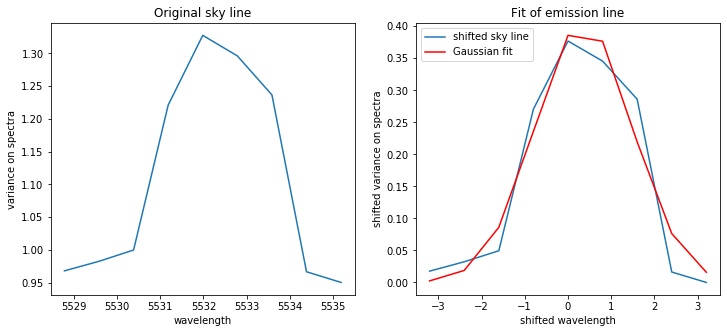

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev     
    ------------------ ------------------ -----------------
    1.7966162925772422 -0.990501385253125 1.488198361551066


<Figure size 432x288 with 0 Axes>

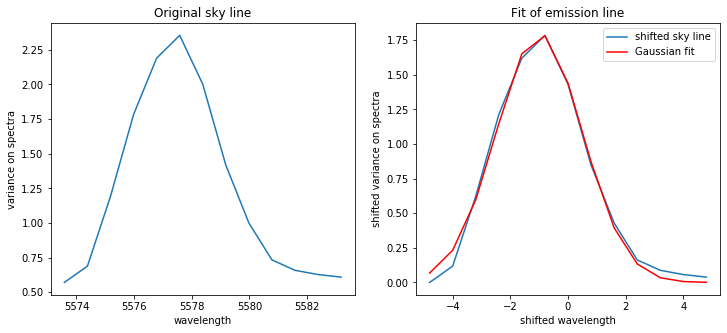

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    0.8639319690034882 -0.08303239510669466 1.5770211763502617


<Figure size 432x288 with 0 Axes>

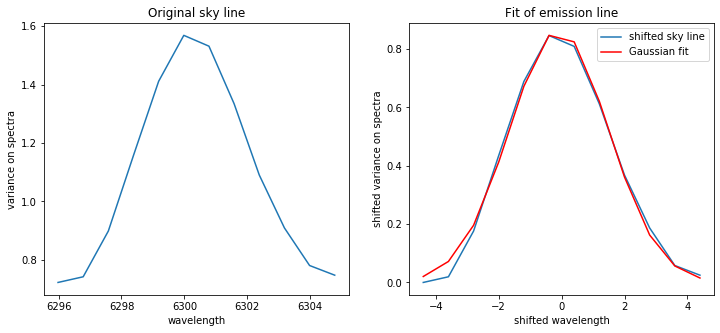

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev     
    ------------------ -------------------- -----------------
    0.3827264984247829 -0.18033631784334064 1.822105002774997


<Figure size 432x288 with 0 Axes>

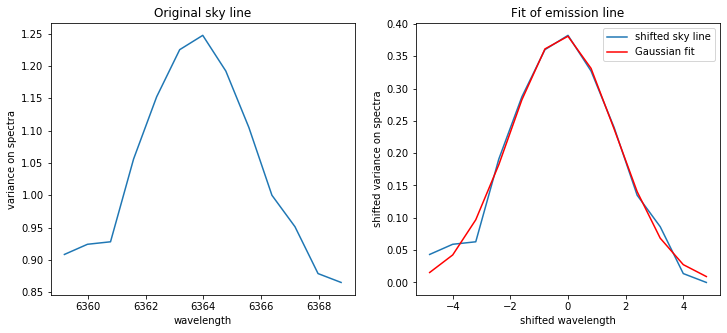

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev      
    ------------------ ------------------ ------------------
    0.6080876304166865 0.5990085837457819 1.4589188292906483


<Figure size 432x288 with 0 Axes>

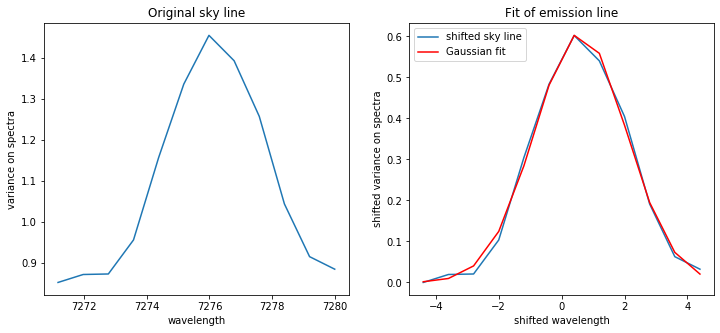

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev      
    ------------------ ------------------- ------------------
    0.8331362635101065 -0.6136843872943817 1.3350103469676535


<Figure size 432x288 with 0 Axes>

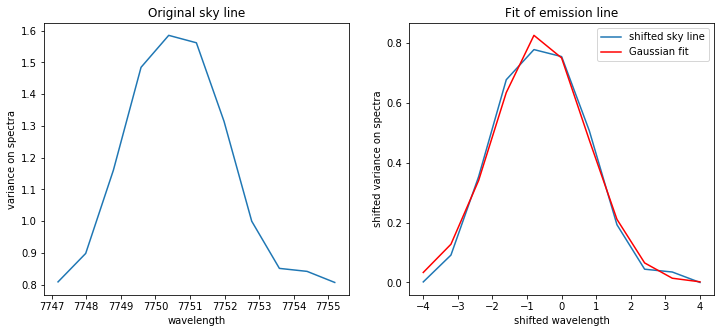

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    0.7269354352820391 -0.12531824807134243 1.3552110212308017


<Figure size 432x288 with 0 Axes>

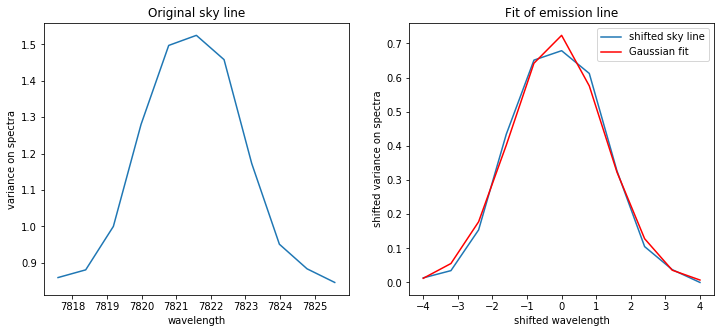

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev     
    ------------------ ------------------ -----------------
    0.9940663711024262 0.7359170591616931 1.401066675483892


<Figure size 432x288 with 0 Axes>

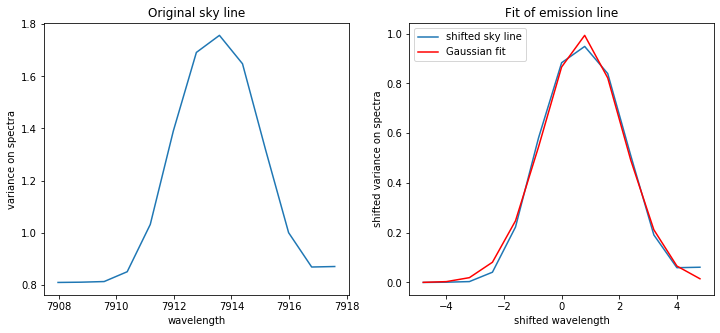

<Figure size 432x288 with 0 Axes>

In [21]:
best_fit = []
for i,p in enumerate(data_sky_line):
    data_sky_line[i] = data_sky_line[i] / np.median(data_sky_line[i])
    x= lamda_sky_line[i] - np.median(lamda_sky_line[i])
    y= data_sky_line[i] - np.min(data_sky_line[i])
    
    best_fit_gauss = fitter_gauss(model_gauss, x, y)
    best_fit.append(best_fit_gauss)
    
    print(best_fit_gauss)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(lamda_sky_line[i], data_sky_line[i])
    ax1.set_title('Original sky line')
    ax1.set_xlabel('wavelength')
    ax1.set_ylabel('variance on spectra')
    
     
    ax2.plot(x, y, label='shifted sky line') 
    ax2.plot(x, best_fit_gauss(x), 'r', label='Gaussian fit')
    ax2.set_title('Fit of emission line')
    ax2.set_xlabel('shifted wavelength')
    ax2.set_ylabel('shifted variance on spectra')
    plt.legend()
    plt.show()
    plt.figure()

In [12]:
# Calculating the average value of the std_dev.
s= 0
for i,p in enumerate(best_fit):
    s += p.stddev.value
    #print(i)
print('average : %f' %(s/ (i+1)))

average : 1.443888


Text(0, 0.5, 'FWHM')

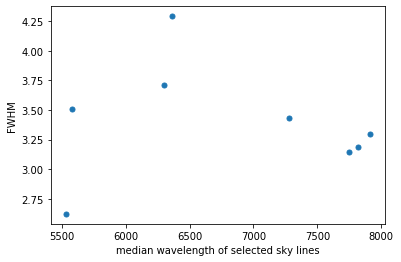

In [29]:
wav = np.zeros(len(lamda_sky_line))
fwhm = np.zeros(len(lamda_sky_line))
for i,p in enumerate(lamda_sky_line):
    wav[i] = np.median(p)
    fwhm[i] = best_fit[i].stddev.value * 2.355
plt.plot(wav, fwhm, '.', ms=10)
plt.xlabel('median wavelength of selected sky lines')
plt.ylabel('FWHM')